# From Prompt to Response. A Look inside Transformer Models

Transformer models are now the dominant deep learning architecture, replacing CNNs and RNNs. But how do they generate outputs from input prompts? In this notebook, we explore the Transformer architecture, the role of its core components, and walk through a quick tutorial on how output generation works.

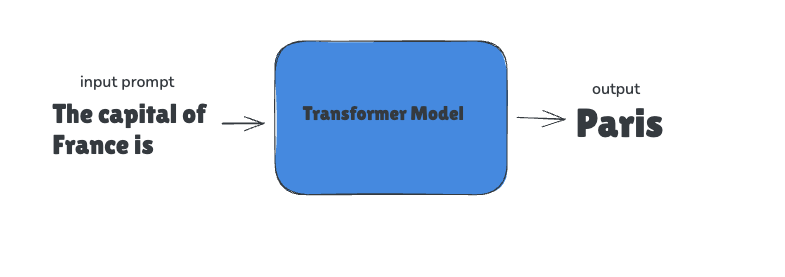

## Imports

In [1]:
!pip install transformers -Uqq

In [2]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

## Input Prompt

To ask the model for the capital of France, we create an input prompt: **prompt = "The capital of France is"**. This prompt is then passed to the large language model (LLM).

In [11]:
prompt = 'The capital of France is'

## Tokens and Tokenizer

Models cannot process raw text directly, so the input must first be tokenized—broken down into smaller units called tokens. Tokens can be words, subwords, or characters (read more about tokens and tokenization [here](https://medium.com/@charmainemahachi/all-you-need-to-know-about-tokenization-145aa540bd11)). For simplicity, this example assumes word-level tokenization.

Each unique token becomes part of the model’s **vocabulary**, which is managed by the tokenizer. The tokens are then converted into numerical representations called **embedding vectors**. These embeddings, stored within the model, allow it to learn and recognize patterns in the text.

In [12]:
tokenizer = AutoTokenizer.from_pretrained('microsoft/Phi-3-mini-4k-instruct')

In [13]:
input_ids = tokenizer(prompt, return_tensors='pt').input_ids.to('cuda')
input_ids

tensor([[ 450, 7483,  310, 3444,  338]], device='cuda:0')

## Loading a model

At this point, the prompt has been tokenized and converted into embedding vectors. These embeddings are then passed into the model for processing.

In [14]:
model = AutoModelForCausalLM.from_pretrained(
    'microsoft/Phi-3-mini-4k-instruct',
    device_map='cuda',
    torch_dtype='auto',
    #trust_remote_code=True,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [16]:
model

Phi3ForCausalLM(
  (model): Phi3Model(
    (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
    (layers): ModuleList(
      (0-31): 32 x Phi3DecoderLayer(
        (self_attn): Phi3Attention(
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (qkv_proj): Linear(in_features=3072, out_features=9216, bias=False)
        )
        (mlp): Phi3MLP(
          (gate_up_proj): Linear(in_features=3072, out_features=16384, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (activation_fn): SiLUActivation()
        )
        (input_layernorm): Phi3RMSNorm((3072,), eps=1e-05)
        (post_attention_layernorm): Phi3RMSNorm((3072,), eps=1e-05)
        (resid_attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_mlp_dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (norm): Phi3RMSNorm((3072,), eps=1e-05)
    (rotary_emb): Phi3RotaryEmbedding()
  )
  (lm_head): Linear(in_features=3072, out_featur

Inside the model, the embedding vectors pass through layers of self-attention, dropout, and feed-forward neural networks. The final hidden states are then projected through the **lm_head**, which outputs a vector whose size equals the tokenizer’s **vocabulary**. This vector contains scores for each token, which are used to select the next output token.

In [17]:
model_output = model.model(input_ids)
model_output

BaseModelOutputWithPast(last_hidden_state=tensor([[[-0.3047,  1.1953,  0.2988,  ..., -0.3008,  0.6758,  0.1406],
         [-0.1318,  0.3320,  0.3906,  ...,  0.5703, -0.1494, -0.6172],
         [-0.5781,  1.0781,  1.5469,  ..., -0.4121,  0.2871,  0.3906],
         [-0.3984,  0.6680,  0.2520,  ..., -0.0732,  0.7969, -0.6719],
         [-0.6758,  0.6953,  0.5586,  ...,  0.2617,  0.1855, -0.2812]]],
       device='cuda:0', dtype=torch.bfloat16, grad_fn=<MulBackward0>), past_key_values=DynamicCache(layers=[DynamicSlidingWindowLayer, DynamicSlidingWindowLayer, DynamicSlidingWindowLayer, DynamicSlidingWindowLayer, DynamicSlidingWindowLayer, DynamicSlidingWindowLayer, DynamicSlidingWindowLayer, DynamicSlidingWindowLayer, DynamicSlidingWindowLayer, DynamicSlidingWindowLayer, DynamicSlidingWindowLayer, DynamicSlidingWindowLayer, DynamicSlidingWindowLayer, DynamicSlidingWindowLayer, DynamicSlidingWindowLayer, DynamicSlidingWindowLayer, DynamicSlidingWindowLayer, DynamicSlidingWindowLayer, Dynamic

In [22]:
lm_head_output = model.lm_head(model_output[0])
lm_head_output

tensor([[[24.7500, 24.8750, 22.7500,  ..., 19.0000, 19.0000, 19.0000],
         [31.0000, 31.5000, 26.0000,  ..., 25.8750, 25.8750, 25.8750],
         [31.3750, 28.8750, 31.0000,  ..., 26.2500, 26.2500, 26.2500],
         [33.0000, 31.8750, 36.0000,  ..., 27.7500, 27.7500, 27.7500],
         [27.8750, 29.5000, 28.0000,  ..., 20.3750, 20.3750, 20.3750]]],
       device='cuda:0', dtype=torch.bfloat16, grad_fn=<UnsafeViewBackward0>)

So how do we go from these probability scores to one word being generated?

## Decoding Strategy
A decoding strategy determines how the model selects a single token from the probability distribution. Common methods include:

* Greedy Search
* Beam Search
* Sampling

In this example, we use greedy decoding, which always selects the token with the highest probability at each step.

In [24]:
token_id = lm_head_output[0, -1].argmax(-1)
tokenizer.decode(token_id)

'Paris'

And that's how Trasformers convert text into tokens and embeddings, process them through attention and feed-forward layers, and use the lm_head to produce token probabilities. Decoding strategies then select the final output, enabling the model to generate coherent responses from any prompt.